In [88]:
import numpy as np
import pandas as pd
import pandas_datareader as web
import matplotlib.pyplot as plt
import datetime
import math

In [89]:
from pypfopt import expected_returns
from pypfopt import risk_models
from pypfopt import efficient_frontier
from pypfopt import objective_functions
from pypfopt import black_litterman, risk_models
from pypfopt import BlackLittermanModel, plotting

In [90]:
import pandas as pd
import pandas_datareader as web
import datetime

def _load_prices(
    ticker: str,
    data_source: str = 'yahoo',
    end: str = datetime.date.today()
) -> pd.DataFrame:
    return web.DataReader(name = ticker, data_source = data_source, start = '2000-01-01', end = end).loc[:, 'Adj Close']

def load_prices_multitickers(
    tickers: list,
    data_source: str = 'yahoo',
    end: str = datetime.date.today()
) -> list:
    prices = pd.DataFrame()
    for t in tickers:
        prices[t] = _load_prices(t, data_source, end)
        
    return prices.fillna(value=None, method="ffill", axis=0, inplace=False).dropna(axis=0, how='any', inplace=False)

In [91]:
def calc_omega(views):
    variances = []
    for symbol, view in views.items():
        lb, ub  = view[0], view[2]
        std_dev = (ub - lb)/2
        variances.append(std_dev ** 2)
    omega = np.diag(variances)
    return omega

def load_mean_views(views):
    mu = {}
    for symbol, view in views.items():
        mu[symbol] = view[1]
    return mu

In [92]:
def load_gdp_data(fname: str) -> pd.DataFrame:
    world_gdp = pd.read_csv(
        fname, 
        sep=",", 
        header=2,
        index_col="Country Code", 
        #names=["Date", "mkt"], 
        skipinitialspace=True,
        skip_blank_lines=True,
        parse_dates=True,
        infer_datetime_format=True
    ).loc["WLD"].iloc[3:].dropna().astype('float64').reset_index()
    
    world_gdp.loc[:, 'index'] = pd.to_datetime(world_gdp.loc[:, 'index'])
    return world_gdp.set_index('index')

def interpolate_gdp_data(df_gdp : pd.DataFrame) -> pd.DataFrame:
    temp = pd.DataFrame(
        pd.date_range(start=g.index[0], end=g.index[-1], freq='D'),
        columns=["date"]
    )
    temp.loc[:, 'dmy'] = math.nan
    i_gdp = temp.set_index('date').join(df_gdp).drop('dmy', axis=1).interpolate(method = 'akima', axis=0)
    
    return i_gdp

In [93]:
tickers = ['VOO', 'BND', 'VXUS', 'BNDX']
prices=load_prices_multitickers(tickers, 'yahoo')

In [94]:
msci = pd.read_csv("./data/msci.csv", sep=",", header=0, index_col="Date", names=["Date", "mkt"], skipinitialspace=True, skip_blank_lines=True, parse_dates=True, infer_datetime_format=True, thousands=",")
msci

,mkt
Date,
2007-11-30,1291.856
2007-12-31,1275.956
2008-01-31,1170.327
2008-02-29,1173.998
2008-03-31,1152.170
...,...
2021-01-29,2094.703
2021-02-26,2149.293
2021-03-31,2200.156


In [95]:
g = load_gdp_data("./data/API_NY.GDP.MKTP.CD_DS2_en_csv_v2_4251000.csv")
g = pd.DataFrame(interpolate_gdp_data(g).join(prices).dropna(axis=0, how='any', inplace=False).loc[:, "WLD"].rename("mkt"))
g

,mkt
date,
2013-06-04,7.849682e+13
2013-06-05,7.850259e+13
2013-06-06,7.850835e+13
2013-06-07,7.851412e+13
2013-06-10,7.853141e+13
...,...
2020-12-24,9.570453e+13
2020-12-28,9.590192e+13
2020-12-29,9.595139e+13


In [96]:
rets = {}
covs = {}

In [97]:
risk_free_rate=1.005**((1/252)) - 1
risk_free_rate

1.9792027252663047e-05

In [98]:
rets['mhr'] = expected_returns.mean_historical_return(prices, frequency=252)
rets['ehr'] = expected_returns.ema_historical_return(prices, frequency=252, span=252*5)
rets['capmr'] = expected_returns.capm_return(prices, market_prices=g, risk_free_rate=risk_free_rate, compounding=True, frequency=252)

In [99]:
covs['sample_cov'] = risk_models.risk_matrix(prices, method='sample_cov')
covs['semicovariance'] = risk_models.risk_matrix(prices, method='semicovariance', benchmark=risk_free_rate, frequency=252, log_returns=False)
covs['exp_cov'] = risk_models.risk_matrix(prices, method='exp_cov', span=252*5, frequency=252)

In [100]:
covs['ledoiid_wolf_cc'] = risk_models.risk_matrix(prices, method='ledoit_wolf_constant_correlation', frequency=252)
covs['ledoiid_wolf_sf'] = risk_models.risk_matrix(prices, method='ledoit_wolf_single_factor', frequency=252)
covs['ledoiid_wolf_cv'] = risk_models.risk_matrix(prices, method='ledoit_wolf_constant_variance', frequency=252)
covs['oracle_approx'] = risk_models.risk_matrix(prices, method='oracle_approximating', frequency=252)

In [101]:
rets

{'mhr': VOO     0.129076
 BND     0.017749
 VXUS    0.042881
 BNDX    0.022882
 dtype: float64,
 'ehr': VOO     0.140761
 BND    -0.009161
 VXUS    0.036891
 BNDX   -0.007814
 Name: 2022-08-11 00:00:00, dtype: float64,
 'capmr': VOO     0.025676
 BND    -0.000957
 VXUS    0.039477
 BNDX   -0.005058
 Name: mkt, dtype: float64}

In [102]:
covs

{'sample_cov':            VOO       BND      VXUS      BNDX
 VOO   0.030530  0.000350  0.026093  0.000311
 BND   0.000350  0.002209  0.000541  0.001075
 VXUS  0.026093  0.000541  0.029519  0.000223
 BNDX  0.000311  0.001075  0.000223  0.001197,
 'semicovariance':            VOO       BND      VXUS      BNDX
 VOO   0.015886  0.001615  0.014352  0.001199
 BND   0.001615  0.001231  0.001768  0.000687
 VXUS  0.014352  0.001768  0.016402  0.001232
 BNDX  0.001199  0.000687  0.001232  0.000658,
 'exp_cov':            VOO       BND      VXUS      BNDX
 VOO   0.042458  0.001442  0.034218  0.001019
 BND   0.001442  0.003375  0.001282  0.001812
 VXUS  0.034218  0.001282  0.036067  0.000649
 BNDX  0.001019  0.001812  0.000649  0.001844,
 'ledoiid_wolf_cc':            VOO       BND      VXUS      BNDX
 VOO   0.030530  0.000386  0.025784  0.000337
 BND   0.000386  0.002209  0.000572  0.001064
 VXUS  0.025784  0.000572  0.029519  0.000249
 BNDX  0.000337  0.001064  0.000249  0.001197,
 'ledoiid_wolf

In [103]:
mcaps = {
    'VOO': 52370474000000.01,
    'BND': 49000000000000,
    'VXUS': 41315525999999.99,
    'BNDX': 70000000000000
}
mcaps

{'VOO': 52370474000000.01,
 'BND': 49000000000000,
 'VXUS': 41315525999999.99,
 'BNDX': 70000000000000}

In [111]:
delta = black_litterman.market_implied_risk_aversion(g.iloc[:, 0], frequency=252, risk_free_rate=0.005)
delta

1045.9342499582585

In [112]:
delta = black_litterman.market_implied_risk_aversion(msci.iloc[:, 0], frequency=12, risk_free_rate=0.005)
delta

1.8249414447466508

In [113]:
viewdict = {
    "VOO":[-0.04, 0.05, 0.05],
    "BND":[-0.03, 0.02, 0.0],
    "VXUS":[-0.02, 0.04, 0.05],
    "BNDX":[-0.03, 0.01, 0.0]
}
omega = calc_omega(viewdict)
mu = load_mean_views(viewdict)

In [114]:
cov_matrix = covs['oracle_approx']
bl = BlackLittermanModel(cov_matrix, pi="market", market_caps=mcaps, risk_aversion=delta, absolute_views=mu, omega=omega)
rets['bl_post'] = bl.bl_returns()
rets

{'mhr': VOO     0.129076
 BND     0.017749
 VXUS    0.042881
 BNDX    0.022882
 dtype: float64,
 'ehr': VOO     0.140761
 BND    -0.009161
 VXUS    0.036891
 BNDX   -0.007814
 Name: 2022-08-11 00:00:00, dtype: float64,
 'capmr': VOO     0.025676
 BND    -0.000957
 VXUS    0.039477
 BNDX   -0.005058
 Name: mkt, dtype: float64,
 'bl_post': VOO     0.037616
 BND     0.008764
 VXUS    0.036394
 BNDX    0.005440
 dtype: float64}

In [115]:
r = 0.03
expected_return = rets['bl_post']
cov_matrix = covs['oracle_approx']

ef_bl = efficient_frontier.EfficientFrontier(expected_return, cov_matrix, weight_bounds=(0.05, 0.6))
ef_bl.add_objective(objective_functions.L2_reg, gamma=1.0)
#w = ef_bl.max_sharpe(risk_free_rate=0.005)
w = ef_bl.efficient_return(r)
perf_bst = ef_bl.portfolio_performance(verbose=True, risk_free_rate=0.005)

print(w)
print(perf_bst)

Expected annual return: 3.0%
Annual volatility: 12.9%
Sharpe Ratio: 0.19
OrderedDict([('VOO', 0.3874979983510486), ('BND', 0.1337966143606874), ('VXUS', 0.3762768532456064), ('BNDX', 0.1024285340426577)])
(0.03, 0.12869796298548145, 0.194253268816852)


In [116]:
expected_return = rets['bl_post']
cov_matrix = covs['oracle_approx']

ef_bl = efficient_frontier.EfficientFrontier(expected_return, cov_matrix, weight_bounds=(0.05, 0.6))
ef_bl.add_objective(objective_functions.L2_reg, gamma=1.0)
w = ef_bl.max_sharpe(risk_free_rate=0.005)
perf_mshL2 = ef_bl.portfolio_performance(verbose=True, risk_free_rate=0.005)

print(w)
print(perf_mshL2)

Expected annual return: 3.4%
Annual volatility: 15.0%
Sharpe Ratio: 0.19
OrderedDict([('VOO', 0.457280260137712), ('BND', 0.053097490601693), ('VXUS', 0.439622249260595), ('BNDX', 0.05)])
(0.03393783938892036, 0.15042656984394903, 0.1923718623574291)


/root/.pyenv/versions/3.10.1/lib/python3.10/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:257: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  warnings.warn(


In [117]:
expected_return = rets['bl_post']
cov_matrix = covs['oracle_approx']

ef_bl = efficient_frontier.EfficientFrontier(expected_return, cov_matrix)
w = ef_bl.max_sharpe(risk_free_rate=0.005)
perf_msh = ef_bl.portfolio_performance(verbose=True, risk_free_rate=0.005)

print(w)
print(perf_msh)

Expected annual return: 2.1%
Annual volatility: 7.8%
Sharpe Ratio: 0.20
OrderedDict([('VOO', 0.261161254645068), ('BND', 0.5694782040961412), ('VXUS', 0.1693605412587908), ('BNDX', 0.0)])
(0.02097837522437207, 0.07848567521462768, 0.20358333136177334)


In [118]:
expected_return = rets['bl_post']
cov_matrix = covs['oracle_approx']

min_ret = max(0, min(expected_return))
max_ret = min(0.25, max(expected_return))
rets_seq = list(np.arange(min_ret, max_ret, 0.001))

weights = {}
max_sr = -1
max_r = 0.0
for r in rets_seq:
    _ef_bl = efficient_frontier.EfficientFrontier(expected_return, cov_matrix)
    _ef_bl.add_objective(objective_functions.L2_reg, gamma=1.0)
    _w = _ef_bl.efficient_return(r)
    _perf = _ef_bl.portfolio_performance(verbose=False, risk_free_rate=0.005)
    
    weights[r] = (_perf, _w)
    
    if _perf[2] >= max_sr:
        max_sr = _perf[2]
        max_r = r
print("{0}:{1}".format(max_r, max_sr))
print(weights[max_r])

0.02143999480607678:0.1965206037942707
((0.021665787067739403, 0.08480427367903941, 0.1965206037942707), OrderedDict([('VOO', 0.2434212426027899), ('BND', 0.2562965458301839), ('VXUS', 0.2436400485101734), ('BNDX', 0.256642163056853)]))


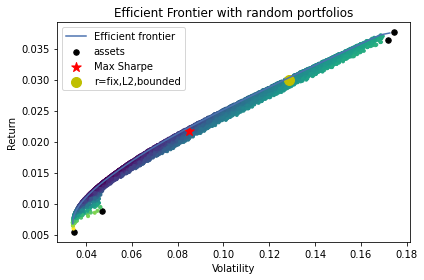

In [119]:
expected_return = rets['bl_post']
cov_matrix = covs['oracle_approx']

ef_for_plot = efficient_frontier.EfficientFrontier(expected_return, cov_matrix)

fig, ax = plt.subplots()
plotting.plot_efficient_frontier(ef_for_plot, ax=ax, show_assets=True)

# Generate random portfolios
n_samples = 10000
w = np.random.dirichlet(np.ones(len(expected_return)), n_samples)
r = w.dot(expected_return)
s = np.sqrt(np.diag(w @ cov_matrix @ w.T))
sharpes = r / s
ax.scatter(s, r, marker=".", c=sharpes, cmap="viridis_r")

ret_tangent, std_tangent, _ = weights[max_r][0]
ax.scatter(std_tangent, ret_tangent, marker="*", s=100, c="r", label="Max Sharpe")

ret_bst, std_bst, _ = perf_bst
ax.scatter(std_bst, ret_bst, marker="o", s=100, c="y", label="r=fix,L2,bounded")

ax.set_title("Efficient Frontier with random portfolios")
ax.legend()
plt.tight_layout()
plt.savefig("ef_scatter.png", dpi=200)
plt.show()

In [120]:
from sklearn.model_selection import TimeSeriesSplit

In [121]:
tscv = TimeSeriesSplit(n_splits=3, max_train_size=252*5, test_size=252, gap=0)
for train, test in tscv.split(prices):
    print(prices.iloc[train, :])
    print("\n")

                   VOO        BND       VXUS       BNDX
Date                                                   
2014-08-11  153.701431  66.679680  42.107735  43.138111
2014-08-12  153.519730  66.622849  42.067913  43.138111
2014-08-13  154.601181  66.744576  42.346661  43.204842
2014-08-14  155.276031  66.809502  42.505959  43.263241
2014-08-15  155.232727  66.931206  42.466122  43.254887
...                ...        ...        ...        ...
2019-08-06  251.585052  78.416100  45.886150  53.843861
2019-08-07  251.756470  78.416100  46.088169  54.065281
2019-08-08  256.669312  78.481369  46.620766  53.889996
2019-08-09  254.879364  78.341415  46.262646  53.936127
2019-08-12  251.889694  78.686630  45.812691  53.991474

[1260 rows x 4 columns]


                   VOO        BND       VXUS       BNDX
Date                                                   
2015-08-11  167.937332  68.188705  40.569569  44.883270
2015-08-12  168.086548  68.163651  40.307732  44.891750
2015-08-13  167.90222